In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import cmath 

#### The data is here

/work/ollie/gallen/data_4_TR/

it contains 6 experiments:

LGM  ORB002  ORB006  ORB02lgm  ORB06lgm  PI

For each experiment, it has files:

U10 and V10 -->    xxx_u10_v10_ymonmean_r360x180.nc

T (VAR: THO), S (VAR: SAO), Sea ice (Var: SICOMO) and SSH (Var: ZO) -->    xxx_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc

OCN-U and OCN-V -->    xxx_UKOandVKE_ymonmean_UVrotated_r360x180.nc

In [57]:
ls

LGM/
LGM_awicm/
ORB002/
ORB006/
ORB02lgm/
ORB06lgm/
PI/
PI_awicm/
README.md
driftforecast_MOSAiC.ipynb
driftforecast_MOSAiC_concentration.ipynb
driftforecast_MOSAiC_example.ipynb
driftforecast_MOSAiC_forParticipants.ipynb
driftforecast_MOSAiC_forcing.ipynb
driftforecast_MOSAiC_targets.ipynb
pyberg_standalone.ipynb
pyberg_standalone_classes.ipynb
pyberg_standalone_classes_LGM.ipynb
pyberg_standalone_classes_NEW_PI.ipynb
pyberg_standalone_classes_works.ipynb
pyberg_standalone_toXun.ipynb
pyberg_standalone_toXun_works.ipynb


In [58]:
cd PI

/Users/trackow/Documents/science-icebergs-lgm/PI


In [59]:
ls

PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc
PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc
PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_UVrotated_r360x180.nc


In [60]:
mv PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_UVrotated_r360x180.nc PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc

In [61]:
!ncdump -h PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc

netcdf PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180 {
dimensions:
	lon = 360 ;
	lat = 180 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double time(time) ;
		time:standard_name = "time" ;
		time:units = "day as %Y%m%d.%f" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
	float u10(time, lat, lon) ;
		u10:long_name = "10m u-velocity" ;
		u10:units = "m/s" ;
		u10:code = 165 ;
		u10:table = 128 ;
	float v10(time, lat, lon) ;
		v10:long_name = "10m v-velocity" ;
		v10:units = "m/s" ;
		v10:code = 166 ;
		v10:table = 128 ;

// global attributes:
		:CDI = "Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/cdi)" ;
		:Conventions = "CF-1.4" ;
		:history = "Mon Apr 20 20:53:19 2020: cdo

### look at the data

In [62]:
# a useful function we'll need

r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km

In [63]:
# load interpolated COSMO data (1x1 degree)
def loaddate_ofCOSMO(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['lev'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [64]:
# load interpolated FESOM data (1x1 degree)
def loaddate_ofFESOM(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_yr3200to3299_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['depth'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [65]:
def plot_field(plotfield, cbar_label='field', vmin=-2., vmax=2.):
    
    m = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='l')
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
    m.drawcoastlines()

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    # plot
    lon_map,lat_map=m(XX[:,:],YY[:,:])
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

    # colorbar
    cbar=plt.colorbar()
    cbar.set_label(cbar_label)

    plt.show()

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...


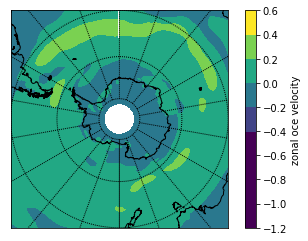

In [66]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_UO'
variable='UKO'
cbar_label='zonal oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...


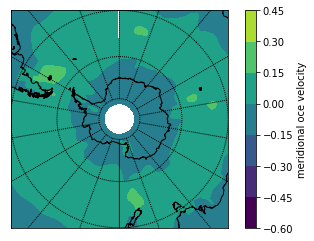

In [67]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_VO'
variable='VKE'
cbar_label='meridional oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


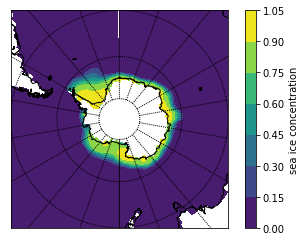

In [68]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_sisnconc'
variable='SICOMO'
cbar_label='sea ice concentration'
vmin, vmax=0.,1. #00.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


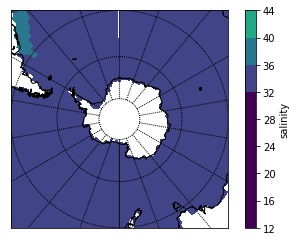

In [69]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_so'
variable='SAO'
cbar_label='salinity'
vmin, vmax=30.,50.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


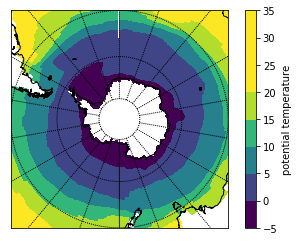

In [70]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_thetao'
variable='THO'
cbar_label='potential temperature'
vmin, vmax=-2.,20.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


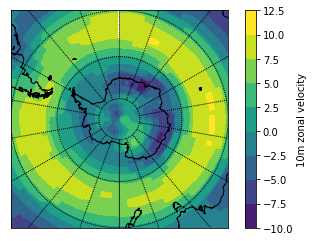

In [71]:
# load the variables and plot them
filen='PI_echam5_last100year_catted_u10_v10' #'MM'
variable='u10'
cbar_label='10m zonal velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


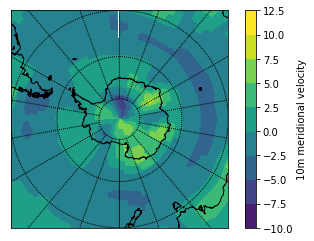

In [72]:
# load the variables and plot them
filen='PI_echam5_last100year_catted_u10_v10'
variable='v10'
cbar_label='10m meridional velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


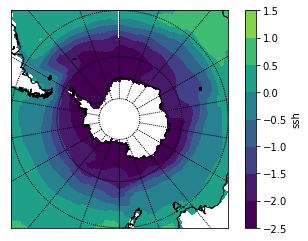

In [77]:
# load the variables and plot them
filen='PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO'
variable='ZO'
cbar_label='ssh'
vmin, vmax=-2.,2.

# load the data
SSH, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan and which month?
month=0
#level=0
SSH[SSH==-9.e+33]=np.nan

# plot the field
plot_field(SSH[month,:,:], cbar_label=cbar_label, vmin=vmin, vmax=vmax)

In [78]:
def compute_gradient(SSH, XX, YY):
    
    # add column to the left and right
    addcol=np.concatenate([np.expand_dims(SSH[:,:,-1],axis=2),SSH,np.expand_dims(SSH[:,:,0], axis=2)],axis=2)
    addcXX=np.concatenate([np.expand_dims(np.ones_like(XX[:,-1])*-1.,axis=1),XX,np.expand_dims(np.ones_like(XX[:,0])*360., axis=1)],axis=1)
    addcYY=np.concatenate([np.expand_dims(YY[:,-1],axis=1),YY,np.expand_dims(YY[:,0], axis=1)],axis=1)
    
    # SSH: (12, 180, 362) # already has columns added left and right
    lats=YY[:,0]
    ddx=np.zeros_like(SSH)
    ddy=np.zeros_like(SSH)
    
    # 1 ... 360 (0 and 361 were added)
    for column in np.arange(1,360+1):
        #print column
        ddx[:,:,column-1]=(addcol[:,:,column+1]-addcol[:,:,column-1])/(2.*111000.)
        
    for row in np.arange(1,180-1):
        #print row
        ddy[:,row,:]=(SSH[:,row+1,:]-SSH[:,row-1,:])/(2.*111000.*np.cos(YY[row,0]*rad))
        
    return ddx, ddy

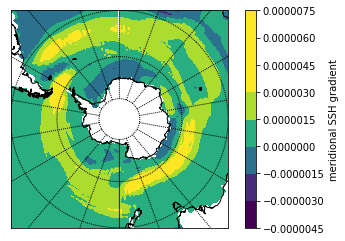

In [79]:
ddx, ddy = compute_gradient(SSH, XX, YY)

# which month and component?
cbar_label="meridional SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

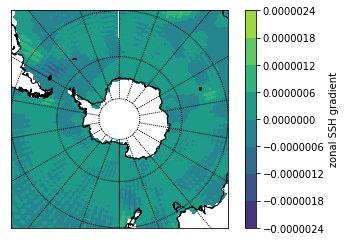

In [80]:
# get sea surface height slope

# which month and component?
cbar_label="zonal SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddx[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

#### The drift (and decay) code

In [143]:
class Buoys:
    
    global rad, r_earth, g, omega, Co, Ca, Cdo_skin, Cda_skin, semiimplicit_coeff, rho_h2o, rho_icb, rho_air, smallestvol_icb, coriolis_slope_only
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    g=9.81
    omega=7.2921e-5 # make latitude dependent later
    # if using iceberg dynamics:
    Co=0.85 # Lichey and Hellmer values
    Ca=1.4 #0.4 # Lichey and Hellmer values
    Cdo_skin=5.0e-3 # Cd_oce_ice in FESOM is 5.0e-3
    Cda_skin=2.5e-3
    rho_icb=850.0 # Silva et al. 2006
    rho_h2o=1027.5
    rho_air=1.293
    smallestvol_icb=1000. #10000. # [m**3]
    semiimplicit_coeff=1.0 # fully impicit # 0.5 default
    coriolis_slope_only=False
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date, L, W, H):
        self.oldlon = lon_start*rad
        self.oldlat = lat_start*rad
        self.lon = lon_start*rad
        self.lat = lat_start*rad
        self.initlon = lon_start*rad
        self.initlat = lat_start*rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        self.L=L
        self.W=W
        self.H=H
        self.mass=L*W*H*rho_icb
        self.D = (rho_icb/rho_h2o)*H
        self.Ao = self.D * L
        self.Aa = (H - self.D) * L
        self.Ad = L * W
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u,new_v, delta_t):
        
        #print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg=self.lon/rad % 360
        lat_deg=np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        idx=getindices_beforestart(self.getdate(), self.startdates)
        lon_deg[idx] = np.nan
        lat_deg[idx] = np.nan
        self.lon[idx] = self.initlon[idx]
        self.lat[idx] = self.initlat[idx]
        self.old_u[idx]=0.
        self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg
    
    def momentum_balance(self, au_ib, av_ib, dt_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib):
        
        new_u_ib = self.old_u + au_ib * dt_ib
        new_v_ib = self.old_v + av_ib * dt_ib
        
        # for semiimplicit version, a matrix multiplication is to be performed
        # (semiimpl. coriolis term and implicit water drag)
 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )
        ocean_drag = (0.5 * Co * rho_h2o * self.Ao * abs_omib + rho_h2o * Cdo_skin * self.Ad * abs_omib_skin)/self.mass
   
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)
        
        # for tests with Coriolis and surface slope only
        if coriolis_slope_only==True:
            ocean_drag=np.zeros_like(abs_omib_skin)
        
        #SI_matrix(1,1) = 1. + dt_ib*ocean_drag
        #SI_matrix(1,2) = dt_ib*fcoriolis*semiimplicit_coeff
        #SI_matrix(2,1) =-SI_matrix(1,2)
        #SI_matrix(2,2) = SI_matrix(1,1)
        #SI_matrix = (1./( SI_matrix(2,2)**2 + SI_matrix(1,2)**2 )) * SI_matrix
        SI_matrix=np.array([[1. + dt_ib*ocean_drag, dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag)], \
                            [-dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag), 1. + dt_ib*ocean_drag]])
        SI_matrix = (1./( SI_matrix[1,1]**2 + SI_matrix[0,1]**2 )) * SI_matrix
        
        # new velocity after matrix multiplication
        # (2, 2, #bergs) x (2, #bergs)
        uv_temp=np.array([new_u_ib, new_v_ib])
        new_u_ib=sum(SI_matrix[0, 0:2, :] * uv_temp[0:2 , :])
        new_v_ib=sum(SI_matrix[1, 0:2, :] * uv_temp[0:2 , :])
        
        # rewrite like this..?
        #SI_matrix = np.einsum('ijn->nij', SI_matrix)
        #new_UV = np.dot(SI_matrix,[new_u_ib, new_v_ib])
        
        # might be melted already
        new_u_ib[self.mass==0.]=0.
        new_v_ib[self.mass==0.]=0.
        
        return new_u_ib, new_v_ib
    
    def compute_areas(self):
        
        # area of iceberg exposed to ocean, atm, (seaice), horizontal area
        self.Ao = self.D * self.L
        self.Aa = (self.H - self.D) * self.L
        # Ai = hi_ib * self.L
        self.Ad = self.L * self.W
    
    def acceleration(self, ua_ib, va_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib, detadx, detady):
        
        l_wave=True
    
        # estimate wave height at the icebergs location (Bigg et al., 1997),
        # so wave_amplitude = 0.5 * wave_height = 0.5 * const. * abs(atm velo)**2
        vel_atm = np.sqrt(ua_ib**2 + va_ib**2)
        wave_amplitude = 0.5 * 0.02025 * vel_atm**2

        # assume that waves have same direction as the winds
        direction_u = ua_ib / vel_atm
        direction_v = va_ib / vel_atm

        # absolute values of relative velocities 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_amib = np.sqrt( (ua_ib - self.old_u)**2 + (va_ib - self.old_u)**2 )
        #abs_imib = sqrt( (ui_ib - u_ib)**2 + (vi_ib - v_ib)**2 )  
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )

        # u-components        
        ocean_drag_u     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * uo_ib)/self.mass #calculate part of it implicitly
        ocean_skin_u     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * uo_skin_ib)/self.mass # calculate part of it implicitly      
        air_drag_u       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (ua_ib - self.old_u))/self.mass
        air_skin_u       = (rho_air * Cda_skin * self.Ad * abs_amib * (ua_ib - self.old_u))/self.mass 
        #ice_drag_u       = (0.5 * Ci * rho_ice * Ai * abs_imib * (ui_ib - u_ib))/mass_ib

        if l_wave==True:
            wave_radiation_u = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_u /self.mass
        else:
            wave_radiation_u = 0.0

        # Fortran code used gradient smoothing for surface slope term
        # call mean_gradient(iceberg_elem, lon_rad, lat_rad, nablaeta)
        # no surface slope due to tides here

        surface_slope_u = -g * detadx #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafux_2D(:,iceberg_elem) ) # -g* nabla ssh


        # v-components     
        ocean_drag_v     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * vo_ib)/self.mass # calculate part of it implicitly
        ocean_skin_v     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * vo_skin_ib)/self.mass #calculate part of it implicitly
        air_drag_v       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (va_ib - self.old_v))/self.mass
        air_skin_v       = (rho_air * Cda_skin * self.Ad * abs_amib * (va_ib - self.old_v))/self.mass 
        #ice_drag_v       = (0.5 * Ci * rho_ice * Ai * abs_imib * (vi_ib - v_ib))/mass_ib

        if l_wave==True:
            wave_radiation_v = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_v /self.mass
        else:
            wave_radiation_v = 0.0

        # no additional surface slope due to tides

        surface_slope_v = -g * detady #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafuy_2D(:,iceberg_elem) )

        #USE (SEMI-)IMPLICIT SCHEME for coriolis term
        
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)

        au_ib = ocean_drag_u \
        + ocean_skin_u    \
        + air_drag_u       \
        + air_skin_u        \
        + wave_radiation_u   \
        + surface_slope_u    \
        + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 

        av_ib = ocean_drag_v \
        + ocean_skin_v    \
        + air_drag_v       \
        + air_skin_v        \
        + wave_radiation_v   \
        + surface_slope_v    \
        - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
        
        
        # TEST FOR CORIOLIS and SLOPE:
        if coriolis_slope_only==True:
            au_ib = surface_slope_u + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 
            av_ib = surface_slope_v - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
            
            
        # might be melted already    
        au_ib[self.mass==0.] = 0.   
        av_ib[self.mass==0.] = 0.
        
        return au_ib, av_ib
    
    def iceberg_meltrates(self, delta_t, sst_ib, conci_ib, uo_ib, vo_ib, ua_ib, va_ib, heuristic=False):
        
        if heuristic==True:
            
            # rate in m/s
            rate_per_month=1.7/100. # area (L*L) red. rate in m/month (Barbat et al., 2020)
            rate_per_second=np.sqrt(rate_per_month/(86400.*30.)) # L red. rate
            
            self.L = self.L - delta_t*rate_per_second
            self.W = self.W - delta_t*rate_per_second
            self.mass = self.H * self.L * self.W * rho_icb
            
        else:
            
            # calculates the empirical melt rates of the iceberg as in 
            # Martin: 'Parameterizing the fresh-water flux from land ice to ocean
            # with interactive icebergs in a coupled climate model'(2010)
            # and Hellmer et al. (1997).
            # (notice that the melt rates are in terms of m/s though, not in m/day)
            
            # bottom melt rate: M_b   [m/s]
            # lateral melt rate: M_v   [m/s]
            # wave erosion: M_e   [m/s]
            # lateral (basal) melt rate: M_bv [m/s]

            # NO (3eq formulation for basal melting yet;
            # use 3D information for T,S and velocities
            # instead of SSTs; M_v depends on 'thermal driving')
  
            # bottom melt (basal turbulent melting rate)
            M_b = np.zeros_like(self.L)
            M_b[self.L>0.] = 0.58 * np.sqrt( (self.old_u[self.L>0.] - uo_ib[self.L>0.])**2 + (self.old_u[self.L>0.] - vo_ib[self.L>0.])**2 )**0.8 * (sst_ib[self.L>0.] + 4.0) / self.L[self.L>0.]**0.2
            M_b = M_b/86400. # conversion of m/day to m/s

            #3-eq. formulation for bottom melting [m/s]    
            #v_ibmino  = sqrt( (u_ib - uo_keel_ib)**2 + (v_ib - vo_keel_ib)**2 )
            #call iceberg_heat_water_fluxes_3eq(ib, M_b, T_keel_ib,S_keel_ib,v_ibmino, depth_ib, tf)

            #3-eq. formulation for lateral 'basal' melting [m/s]
            #v_ibmino  = sqrt( (u_ib - uo_ib)**2 + (v_ib - vo_ib)**2 ) ! depth-average rel. velocity
            #call iceberg_heat_water_fluxes_3eq(ib, M_bv, T_ave_ib,S_ave_ib,v_ibmino, depth_ib/2.0, tf)
            M_bv=M_b

            #'thermal driving', defined as the elevation of ambient water 
            #temperature above freezing point' (Neshyba and Josberger, 1979).
            
            T_ave_ib=sst_ib # use sst for the moment
            tf=-2. # use constant value at the moment
            
            # thermal driving temp
            T_d = (T_ave_ib - tf) * np.ones_like(self.L)
            T_d[T_d < 0.]=0. 
            
            #!write(*,*) 'thermal driving:',T_d,'; Tf:',tf,'T_ave:',T_ave_ib

            #lateral melt (buoyant convection)
            #M_v = 0.00762 * sst_ib + 0.00129 * sst_ib**2
            #M_v = M_v/86400.
            #M_v is a function of the 'thermal driving', NOT just sst! Cf. Neshyba and Josberger (1979)
            M_v = 0.00762 * T_d + 0.00129 * T_d**2
            M_v = M_v/86400.

            #wave erosion
            absamino = np.sqrt( (ua_ib - uo_ib)**2 + (va_ib - vo_ib)**2 )
            sea_state = 3./2.*np.sqrt(absamino) + 1./10.*absamino
            damping = 0.5 * (1.0 + np.cos(conci_ib**3 * np.pi))
            M_e = 1./6. * sea_state * T_d * damping # replaced (sst_ib + 2.0) by Td
            M_e = M_e/86400.
            
            M_b[np.isnan(M_b)]=0.
            M_v[np.isnan(M_v)]=0.
            M_e[np.isnan(M_e)]=0.
            M_bv[np.isnan(M_bv)]=0.
            
        return M_b, M_v, M_e, M_bv
            

    def iceberg_newdimensions(self, delta_t, M_b,M_v,M_e,M_bv):
        
        # changes in this timestep:
        dh_b = M_b*delta_t # change of height..
        dh_v = M_v*delta_t # ..and length due to melting..
        dh_e = M_e*delta_t # ..and due to wave erosion [m].
        dh_bv = M_bv*delta_t # M_bv*dt # change of length due to 'basal meltrate'
        
        # CALCULATION OF WORKING SURFACES AS IN BIGG (1997) & SILVA (2010)
        # basal volume loss
        bvl = dh_b*self.L**2
        
        # lateral volume loss
        lvl_e = dh_e*self.L*self.H + dh_e*self.W*self.H # erosion just at 2 sides
        lvl_b = dh_bv*2.*self.L*self.D + dh_bv*2*self.W*self.D # at all 4 sides
        lvl_v = dh_v*2.*self.L*self.D + dh_v*2*self.W*self.D # at all 4 sides
        # total volume loss
        tvl = bvl + lvl_b + lvl_v + lvl_e # [m^3] per timestep
        volume_before=self.H*self.L*self.W
    
        #if((tvl*rho_icb >= self.mass) or (self.mass <= 1000.*rho_icb)):
        
        # if more ice is to be melted than there is, or when the mass is smaller than allowed
        whereidx=np.logical_or(tvl*rho_icb >= self.mass, self.mass <= smallestvol_icb*rho_icb)
        tvl[whereidx] = self.mass[whereidx] / rho_icb
        self.mass[whereidx] = 0.
        self.L[whereidx] = 0.
        self.W[whereidx] = 0.
        self.H[whereidx] = 0.
        self.D[whereidx] = 0.        
            
        # define last tvl to be erosional loss
        bvl[whereidx] = 0.0
        lvl_b[whereidx] = 0.0
        lvl_v[whereidx] = 0.0
        lvl_e[whereidx] = tvl[whereidx]

        #volume_after=volume_before-tvl
            
        # calculating the new iceberg dimensions
        # print('max dh_b', np.max(dh_b))
        self.H = self.H - dh_b
        self.H[self.H< 0.]=0. # in case basal melt is strong
        self.D = self.H * rho_icb/rho_h2o
    
        # calculate L so that new volume is correct
        volume_after=self.H*self.L*self.W
        self.L[self.H >0.] = np.sqrt(volume_after[self.H >0.]/self.H[self.H >0.])
        self.W = self.L # quadratic at the moment
    
        #distribute dh_e equally between length and width
        #as in code of michael schodlok, but not dh_v? 
        #length_ib= length_ib - dh_v -dh_e/2.
        #width_ib = width_ib  - dh_v -dh_e/2.
    
        #volume_after=height_ib*length_ib*width_ib

        # iceberg smaller than critical value after melting?
        #if (volume_after <= smallestvol_icb):
        whereidx=(volume_after <= smallestvol_icb)
            
        volume_after[whereidx]=0.0
        self.D[whereidx] = 0.0
        self.H[whereidx]= 0.0
        self.L[whereidx]= 0.0
        self.W[whereidx] = 0.0
        tvl[whereidx] = volume_before[whereidx]
        # define last tvl to be erosional loss
        #bvl = 0.0
        #lvl_b = 0.0
        #lvl_v = 0.0
        #lvl_e = tvl
        
        self.mass = self.mass - tvl*rho_icb
    
        #!stability criterion: icebergs are allowed to roll over
        #if(l_weeksmellor) then
        #  call weeksmellor(	depth_ib, height_ib, length_ib, width_ib, &
        #  			rho_h2o, rho_icb, volume_after)
        #end if   
    

        #OUTPUT of averaged meltrates in [m^3 (ice) per day]
        #bvl_mean(ib)=bvl_mean(ib)+(bvl/real(icb_outfreq))
        #lvlv_mean(ib)=lvlv_mean(ib)+(lvl_v/real(icb_outfreq))
        #lvle_mean(ib)=lvle_mean(ib)+(lvl_e/real(icb_outfreq))
        #lvlb_mean(ib)=lvlb_mean(ib)+(lvl_b/real(icb_outfreq))

In [144]:
# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(start_dates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices

In [145]:
# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(XX,YY, Ufield,Vfield, objects, returnidx=False):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    
    # don't change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    #lon_adjust=objects.lon/rad
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((objects.lon/rad,objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx=spatial.KDTree(A).query(tuples)[1]
    
    #if np.any(idx==np.shape(XX[:,:].flatten())[0]):
    #    print(A.min(), A.max(), tuples.min(), tuples.max(), idx)
    #    return np.zeros_like(idx), np.zeros_like(idx)
    #else:
    if returnidx==True:
        return Ufield[idx], Vfield[idx], idx
    else:
        return Ufield[idx], Vfield[idx]

In [146]:
def find_idx_atbuoy_pos(XX,YY, poslon, poslat):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # don't change to -180..180 as assumed in OSISAF data; poslon is 0..360 and
    # the remapped data as well
    #lon_adjust=poslon
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((poslon,poslat)) 
    
    # fast KDTree nearest neighbor method
    return spatial.KDTree(A).query(tuples)[1]

#### Define some icebergs here

In [119]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
poslat=np.ones_like(poslon)*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
lengths=np.ones_like(poslon)*25. # 1000m
widths=np.ones_like(poslon)*25. # 1000m
heights=np.ones_like(poslon)*25. # 250m

# config
initialdate='1900-01-01 12:00:00'
num_times=24   # number of iterations: integrate for x ...
delta_t=86400*30 # ... months [time step in seconds]
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

(35,)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,...,260.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,340.0,350.0


### Let's finally compute the trajectories!

In [102]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [103]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[25:40])

# get ssh
SSH, XX, YY = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=True)
SSH[SSH==-9.e+33]=20. # to have a wall along the coast
SSH[SSH==-9.e+33]=20. # to have a wall along the coast

# compute gradient for sea surface tilt
nablaeta=np.array(np.gradient(SSH, axis=[1,2]))

# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #Ufield, XX, YY = loaddate_ofFESOM('fesom_regular_UO', 'uo', returncoords=True)
    #Vfield, XX, YY = loaddate_ofFESOM('fesom_regular_VO', 'vo', returncoords=True)
    #Ufield=np.ones_like(Ufield)*0.1
    #Vfield=np.ones_like(Ufield)*0.0
    
    # set to nan; which month and level?
    month=i % 12
    level=0
    #Ufield[Ufield==-9999.0]=np.nan
    #Vfield[Vfield==-9999.0]=np.nan
    weights=np.diff(depth[24:40])
    Ufieldl=np.average(Ufield[month,25:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,25:40,:,:], axis=0, weights=weights/np.sum(weights))

    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    U,V=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects)
    
    # don't advect buoys when there is no ice
    #fixed=np.logical_or(U.mask, V.mask)
    #print(U.min(), U.max())
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
[310. 263. 220. 183. 150. 123. 100.  83.  69.  57.  47.  37.  27.  17.
   6.]
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
This is loop #0
This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.000000,90.000000,100.000000,...,260.000000,270.000000,280.000000,290.000000,300.000000,310.000000,320.000000,330.000000,340.000000,350.000000
1900-01-31 12:00:00,9.151221,19.747642,29.659385,39.902498,50.942004,61.227966,71.338313,81.529538,89.189798,99.373936,...,261.401547,271.372539,281.250075,290.536300,299.940155,309.976307,320.209934,330.380965,340.216782,349.441104
1900-03-02 12:00:00,7.387376,19.218147,28.939736,39.668107,52.959773,63.713115,74.029533,83.449733,88.045252,98.264583,...,264.452663,274.554980,284.539452,292.047673,299.840544,309.806679,320.441809,331.014105,340.924581,348.392839
1900-04-01 12:00:00,5.456216,18.592654,28.155390,39.334924,55.317279,65.674485,76.863741,83.527948,87.401605,97.231770,...,267.830759,278.282162,288.607883,293.733865,299.763185,309.519564,320.493134,331.602747,341.955752,347.489178
1900-05-01 12:00:00,3.385160,17.874615,27.329656,38.818036,58.800885,67.187983,80.035819,83.700907,87.170302,96.150804,...,271.363682,282.193203,292.120261,295.114687,299.691089,309.253010,320.559383,332.321756,343.268693,346.761364
1900-05-31 12:00:00,1.536616,17.055131,26.305652,38.438114,63.116593,68.739370,83.182454,85.300611,87.881031,95.133173,...,274.952498,286.179827,295.012368,297.571228,299.611791,308.974125,320.663531,333.061379,344.736834,346.138174
1900-06-30 12:00:00,359.947992,16.038988,25.044216,38.214991,66.759105,70.018813,84.817889,88.277737,89.825809,94.182292,...,278.622596,290.954896,298.198998,300.537121,299.521911,308.668867,320.825510,333.594998,346.091185,345.621792
1900-07-30 12:00:00,358.328980,14.837642,23.791922,37.907473,69.813310,70.990977,84.923135,92.489282,93.245373,93.245148,...,283.173354,295.493932,301.136092,304.874650,299.423932,308.357939,321.029748,334.013618,347.626278,345.803355
1900-08-29 12:00:00,356.575007,13.466854,22.572903,37.972357,72.980551,72.525247,84.965615,97.442796,97.989812,91.967134,...,288.631951,298.993444,305.405484,310.564897,299.335648,308.010548,321.245730,334.501171,349.455286,346.591831
1900-09-28 12:00:00,354.593647,11.961075,21.467950,38.379278,76.519553,74.823043,86.868567,102.673937,103.323280,90.300989,...,293.815232,303.915425,311.038393,315.602520,299.395804,307.647636,321.457273,334.917081,351.418934,347.363183


#### plot the trajectories 

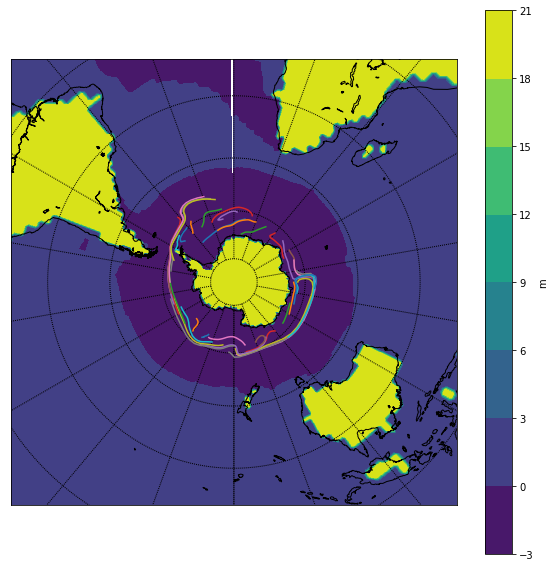

In [104]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='spstere',boundinglat=-10,lon_0=180,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(XX[:,:],YY[:,:])
SSH[SSH==-9999.0]=np.nan
m.contourf(lon_map,lat_map,np.mean(SSH,axis=0))
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    

cbar=plt.colorbar()
cbar.set_label('m')
plt.show()

#### use the momentum balance for icebergs now

In [160]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
lengths=np.ones_like(poslon)*2000. #5000. # 1000m
widths=np.ones_like(poslon)*2000. #5000. # 1000m
heights=np.ones_like(poslon)*250. #0. # 250m

# config
initialdate='1900-01-01 12:00:00'
num_times=240 #120   # number of iterations: integrate for x ...
delta_t=86400*30 # ... days [time step in seconds]
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

(35,)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,...,260.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,340.0,350.0


In [161]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [162]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[0:17])

# get ssh slope
SSH = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=-3.e-6
ddx[SSHnan==-9.e+33]=0.

# get winds
Uafield = loaddate_ofCOSMO('PI_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO('PI_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO('PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    month=i % 12
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
[5720. 5170. 4670. 4195. 3770. 3395. 3070. 2785. 2525. 2290. 2080. 1885.
 1700. 1525. 1365. 1220. 1085.]
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
This is loop #0


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:263: RuntimeWarning: invalid value encountered in less


This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_l

This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30
This is loop #31
This is loop #32
This is loop #33
This is loop #34
This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39
This is loop #40
This is loop #41
This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This is loop #60
This is loop #61
This is loop #62
This is loop #63
This is loop #64
This is loop #65
This is loop #66
This is loop #67
This is loop #68
This is loop #69
This is loop #70
This is loop #71
This is loop #72
This is loop #73
This is loop #

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.000000,90.000000,100.000000,...,260.000000,270.000000,280.000000,290.000000,300.0,310.000000,320.000000,330.000000,340.000000,350.000000
1900-01-31 12:00:00,8.059259,19.297221,29.746715,39.806766,50.616152,61.178482,71.819461,80.877582,89.130603,99.156762,...,263.821569,274.256802,283.780150,293.239206,300.0,309.862815,320.462871,330.498237,340.390390,350.381069
1900-03-02 12:00:00,4.412550,17.852232,29.225697,39.430399,51.793128,63.450367,74.953830,81.027008,89.383993,98.723746,...,271.589145,282.710020,294.148387,301.083703,300.0,310.515009,321.321284,331.113241,341.433842,351.770047
1900-04-01 12:00:00,0.884294,16.240270,28.852415,39.010542,53.148991,65.890162,77.079099,79.587698,91.588534,99.293470,...,279.876125,290.579098,304.577975,309.384426,300.0,312.081212,321.976630,331.340929,343.377929,353.632231
1900-05-01 12:00:00,357.297251,14.719929,29.108372,38.524860,54.830693,69.021633,78.644536,77.867674,94.929129,99.422291,...,288.380039,297.950420,309.005734,313.986754,300.0,313.631772,322.395938,331.559217,345.878646,355.223418
1900-05-31 12:00:00,355.755317,13.419050,30.239282,38.575477,57.507461,72.602567,80.308380,74.919075,98.990754,99.137159,...,296.037644,301.629807,309.633773,315.451689,300.0,315.011354,322.744258,331.909812,348.214555,357.851759
1900-06-30 12:00:00,356.290965,12.010069,32.341312,38.999699,61.115025,75.520531,81.944956,72.028557,104.019444,98.372923,...,302.576510,302.203013,310.662026,316.668610,300.0,316.216525,323.301220,332.440788,350.585627,0.726793
1900-07-30 12:00:00,358.087075,10.227942,34.924540,39.940204,61.989932,77.262074,83.220023,71.433568,110.490127,96.435358,...,305.763362,303.325643,312.416385,317.854956,300.0,317.791677,324.761480,333.072555,354.566189,2.147141
1900-08-29 12:00:00,0.676427,8.090407,37.947634,41.059513,60.890628,80.207334,84.309554,72.865277,117.118507,93.530279,...,306.012381,304.062100,313.867011,318.937701,300.0,319.827384,326.405680,333.738484,359.163545,4.050046
1900-09-28 12:00:00,2.214684,5.622926,41.400360,41.558337,60.890628,85.173319,84.678885,74.236509,123.586152,87.718732,...,306.714841,304.695435,315.131517,320.000223,300.0,322.058713,327.532409,334.139291,3.382452,6.960480


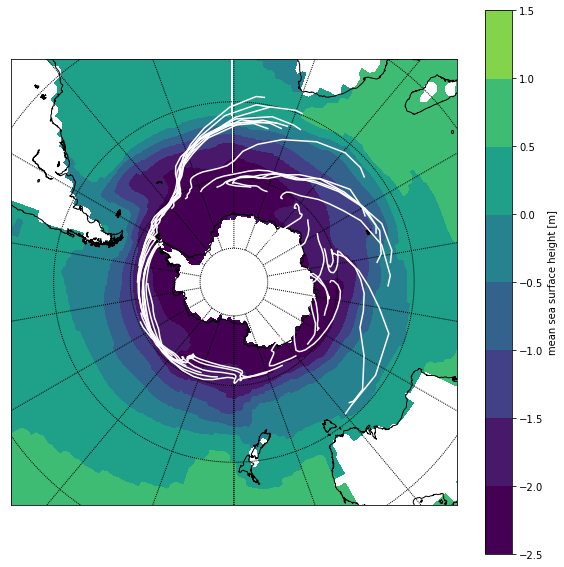

In [163]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(XX[:,:],YY[:,:])
SSH[SSH==-9.e+33]=np.nan
m.contourf(lon_map,lat_map,np.mean(SSH,axis=0),vmin=-2., vmax=2.)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj, 'w')
    

cbar=plt.colorbar()
cbar.set_label('mean sea surface height [m]')
plt.show()

In [155]:
objects.mass

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.05780401e+10,
       1.31028035e+11, 1.65063496e+11, 0.00000000e+00, 0.00000000e+00,
       1.41304572e+11, 1.63148101e+11, 1.79346473e+11, 1.54982176e+11,
       1.75368393e+11, 1.83513886e+11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [165]:
lats_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000,...,-62.000000,-62.000000,-62.000000,-62.000000,-62.0,-62.000000,-62.000000,-62.000000,-62.000000,-62.000000
1900-01-31 12:00:00,-62.042883,-62.016267,-62.032403,-62.085709,-62.197741,-62.218627,-62.036820,-61.928156,-61.807847,-61.983635,...,-62.069755,-62.058216,-61.920854,-61.793312,-62.0,-61.943514,-61.980687,-61.979953,-61.807338,-61.969852
1900-03-02 12:00:00,-62.127804,-62.026431,-62.050283,-62.240757,-62.536617,-62.537108,-62.165103,-61.576447,-61.035392,-61.962433,...,-62.270710,-62.191867,-61.853268,-61.368129,-62.0,-61.800863,-61.925304,-61.931465,-61.405184,-61.834522
1900-04-01 12:00:00,-62.055990,-61.850433,-61.700703,-62.078514,-62.885750,-62.671397,-62.271192,-61.005678,-59.867944,-61.939747,...,-62.350879,-62.012870,-62.155262,-61.568524,-62.0,-61.579322,-61.732964,-61.791267,-61.027359,-61.473716
1900-05-01 12:00:00,-61.695801,-61.527124,-60.786274,-61.483771,-63.297376,-62.683633,-62.297850,-60.580480,-59.078364,-61.896965,...,-62.033324,-61.588493,-62.264579,-61.784418,-62.0,-61.257026,-61.395479,-61.541479,-60.554993,-60.878353
1900-05-31 12:00:00,-61.287940,-61.392432,-59.885076,-61.019014,-64.355374,-62.742000,-62.283650,-60.397935,-58.951497,-61.941653,...,-61.763939,-61.418548,-61.970522,-61.541945,-62.0,-61.036247,-61.120844,-61.329226,-60.034604,-60.367859
1900-06-30 12:00:00,-60.948442,-61.475537,-59.318244,-60.935198,-66.345610,-62.956429,-62.208447,-60.307109,-59.087016,-62.205140,...,-61.944646,-61.352937,-61.757226,-61.487416,-62.0,-60.992825,-60.979339,-61.196033,-59.591236,-60.068982
1900-07-30 12:00:00,-60.576640,-61.614148,-58.978712,-61.027024,-68.196185,-63.182903,-62.070571,-60.212599,-59.361244,-62.656484,...,-62.021099,-61.222989,-61.644058,-61.434607,-62.0,-60.931330,-60.913194,-61.073549,-59.230897,-59.867689
1900-08-29 12:00:00,-60.250916,-61.712198,-58.469638,-61.272582,-68.910894,-63.784524,-61.693967,-60.159076,-59.881186,-63.339645,...,-61.754711,-61.074961,-61.568096,-61.340166,-62.0,-60.828445,-60.819166,-60.903737,-58.908986,-59.697124
1900-09-28 12:00:00,-59.925090,-61.646340,-57.456519,-61.562888,-68.910894,-64.785361,-60.959393,-60.221476,-60.331540,-65.800854,...,-61.451428,-60.923343,-61.458753,-61.230422,-62.0,-60.707508,-60.708516,-60.688922,-58.420160,-59.491114


In [111]:
#Implement Weeks Mellor to get less deep bergs; integrate the upper ocean in the end; might do a turn?!

In [186]:
lons_df.to_csv('PI_lons_to_Xun.csv')
lats_df.to_csv('PI_lats_to_Xun.csv')

In [113]:
depth[38:40]

array([17.,  6.])

In [187]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/PI'

In [183]:
lons_df.iteritems()

<generator object iteritems at 0x829742eb0>

In [184]:
{name: col.values for name, col in lons_df.iteritems()}

{0: array([ 10.        ,   8.05925892,   4.41255026,   0.88429377,
        357.29725099, 355.755317  , 356.29096452, 358.08707458,
          0.67642687,   2.21468423,   4.26167433,   7.45007384,
         10.16572377,  11.93541037,  13.47187911,  15.0763218 ,
         17.63220572,  21.31326043,  25.96473142,  32.35725165,
         40.10988081,  49.22939414,  59.5232137 ,  70.57679815,
         79.16902329,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  82.15891697,  82.15891697,
         82.15891697,  82.15891697,  

In [188]:
lons_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
1900-01-01 12:00:00,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.000000,90.000000,100.000000,...,260.000000,270.000000,280.000000,290.000000,300.0,310.000000,320.000000,330.000000,340.000000,350.000000
1900-01-31 12:00:00,8.059259,19.297221,29.746715,39.806766,50.616152,61.178482,71.819461,80.877582,89.130603,99.156762,...,263.821569,274.256802,283.780150,293.239206,300.0,309.862815,320.462871,330.498237,340.390390,350.381069
1900-03-02 12:00:00,4.412550,17.852232,29.225697,39.430399,51.793128,63.450367,74.953830,81.027008,89.383993,98.723746,...,271.589145,282.710020,294.148387,301.083703,300.0,310.515009,321.321284,331.113241,341.433842,351.770047
1900-04-01 12:00:00,0.884294,16.240270,28.852415,39.010542,53.148991,65.890162,77.079099,79.587698,91.588534,99.293470,...,279.876125,290.579098,304.577975,309.384426,300.0,312.081212,321.976630,331.340929,343.377929,353.632231
1900-05-01 12:00:00,357.297251,14.719929,29.108372,38.524860,54.830693,69.021633,78.644536,77.867674,94.929129,99.422291,...,288.380039,297.950420,309.005734,313.986754,300.0,313.631772,322.395938,331.559217,345.878646,355.223418
1900-05-31 12:00:00,355.755317,13.419050,30.239282,38.575477,57.507461,72.602567,80.308380,74.919075,98.990754,99.137159,...,296.037644,301.629807,309.633773,315.451689,300.0,315.011354,322.744258,331.909812,348.214555,357.851759
1900-06-30 12:00:00,356.290965,12.010069,32.341312,38.999699,61.115025,75.520531,81.944956,72.028557,104.019444,98.372923,...,302.576510,302.203013,310.662026,316.668610,300.0,316.216525,323.301220,332.440788,350.585627,0.726793
1900-07-30 12:00:00,358.087075,10.227942,34.924540,39.940204,61.989932,77.262074,83.220023,71.433568,110.490127,96.435358,...,305.763362,303.325643,312.416385,317.854956,300.0,317.791677,324.761480,333.072555,354.566189,2.147141
1900-08-29 12:00:00,0.676427,8.090407,37.947634,41.059513,60.890628,80.207334,84.309554,72.865277,117.118507,93.530279,...,306.012381,304.062100,313.867011,318.937701,300.0,319.827384,326.405680,333.738484,359.163545,4.050046
1900-09-28 12:00:00,2.214684,5.622926,41.400360,41.558337,60.890628,85.173319,84.678885,74.236509,123.586152,87.718732,...,306.714841,304.695435,315.131517,320.000223,300.0,322.058713,327.532409,334.139291,3.382452,6.960480
